In [3]:
!pip install pycuda
!pip install matplotlib

In [20]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import numpy
import time
import math

NUM_THREADS_ARRAY = [16, 32, 64, 128, 256]
NUM_ITERATIONS = 1000000

execution_times = []

for NUM_THREADS in NUM_THREADS_ARRAY:

  mod = SourceModule("""
      #include <curand_kernel.h>
      #include <curand.h>

      extern "C" {
        __global__ void calculate_pi(int* counts, int iterations)
        {
          int id = threadIdx.x + blockDim.x * blockIdx.x;
          float x, y, z;

          curandState state;
          curand_init(id, id, 0, &state);
          for (int i = 0; i < iterations; i++)
          {
            x = curand_uniform(&state);
            y = curand_uniform(&state);
            z = sqrt((x*x) + (y*y));
            
            if (z <= 1.0)
            {
                counts[id]++;
            }
          }
        }
      }
  """, no_extern_c=True)

  counts = numpy.zeros(NUM_THREADS).astype(numpy.int32)
  func = mod.get_function("calculate_pi")
  time_pre = time.time()
  func(cuda.InOut(counts), numpy.int32(NUM_ITERATIONS), block=(NUM_THREADS, 1, 1))
  time_post = time.time() - time_pre
  execution_times.append(time_post)
  print(time_post)
  pi = 4 * numpy.sum(counts) / (NUM_THREADS * NUM_ITERATIONS)

  print("PI:", pi, "Accuracy:", pi - math.pi)


0.23927950859069824
PI: 3.14197375 Accuracy: 0.00038109641020689367
0.12417960166931152
PI: 3.141716375 Accuracy: 0.00012372141020700056
0.1149137020111084
PI: 3.1417025625 Accuracy: 0.00010990891020679072
0.1146535873413086
PI: 3.141748375 Accuracy: 0.00015572141020703256
0.1257340908050537
PI: 3.1418059375 Accuracy: 0.0002132839102069184


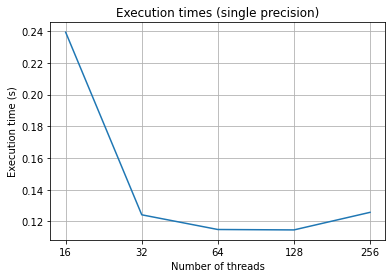

In [21]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(execution_times)
ax.locator_params(axis='x', nbins=5)
NUM_THREADS_ARRAY.insert(0,0)
ax.set_xticklabels(NUM_THREADS_ARRAY, fontdict=None, minor=False)

ax.set(xlabel='Number of threads', ylabel='Execution time (s)',
       title='Execution times (single precision)')
ax.grid()

plt.show()